# Imports

In [1]:
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data

In [2]:
graph_path = "./massachusetts.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [3]:
election = "SEN14"

In [4]:
for n in graph.nodes:
    graph.nodes[n][election+"D"] = int(graph.nodes[n][election+"D"].replace(",",""))
    graph.nodes[n][election+"R"] = int(graph.nodes[n][election+"R"].replace(",",""))

In [5]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

6728169.714491896


In [6]:
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 0.14079928066162706,
 'area': 0.0006839594270970608,
 'District': '1-1',
 'Name': 'Boston Ward 1 Precinct 1',
 'Shape_Le_1': 0.2370997653,
 'Shape_Area': 0.00068395943,
 'City/Town': 'Boston',
 'Ward': '1',
 'Pct': '1',
 'SEN12D': '604',
 'SEN12R': '251',
 'PRES12D': '645',
 'PRES12R': '188',
 'SEN13D': '241',
 'SEN13R': '84',
 'SEN14D': 439,
 'SEN14R': 109,
 'PRES16D': '755',
 'PRES16R': '189',
 'CD': '07',
 'TOTPOP': 2127.1376074597397,
 'NH_WHITE': 1232.8953012907173,
 'NH_BLACK': 58.91581379295309,
 'NH_AMIN': 11.999999891822892,
 'NH_ASIAN': 66.91581078543187,
 'NH_NHPI': 1.000000016734194,
 'NH_OTHER': 44.747434355389224,
 'HISP': 710.6632473266911,
 'H_WHITE': 428.83162612047374,
 'H_BLACK': 37.00000046135009,
 'H_AMIN': 4.999999662849095,
 'H_ASIAN': 5.999999756691586,
 'H_NHPI': 4.999999786413395,
 'H_OTHER': 228.83162153891337,
 'VAP': 1714.474357046681,
 'HVAP': 502.8316220818222,
 'WVAP': 1071.8952982689327,
 'BVAP': 37.91581339079

In [18]:
%%time
num_dist = 9

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    election: Election(election, {"democratic":"SEN14D","republican":"SEN14R"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.005,
                               3)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.009,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

CPU times: user 3.34 s, sys: 33.6 ms, total: 3.37 s
Wall time: 3.38 s


## Acceptance Functions

In [8]:
%%time
def push_rep(partition):
    bound = 1
    if partition.parent is not None:
        if sorted(partition.parent[election].percents("republican"))[-1] >= sorted(partition[election].percents("republican"))[-1]:
            bound = 0
    return random.random() < bound

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 13.1 µs


In [9]:
%%time
def one_rep(partition):
    bound = 1
    if partition.parent is not None:
        if sorted(partition.parent[election].percents("republican"))[-1] < 0.5:
            if sorted(partition.parent[election].percents("republican"))[-1] >= sorted(partition[election].percents("republican"))[-1]:
                bound = 0
        else:
            if sorted(partition[election].percents("republican"))[-1] < 0.5:
                bound = 0      
    return random.random() < bound

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [10]:
%%time 
def one_rep_probabalistic(partition):
    parent_percents = sorted(partition.parent[election].percents("republican"), reverse=True)
    percents = sorted(partition[election].percents("republican"), reverse=True)
    
    bound = 1
    
    if partition.parent is not None:
        if parent_percents[0] < 0.5:
            if parent_percents[0] >= percents[0]:
                bound = 10 * (parent_percents[0] - percents[0]) # If 0R, choose a worse 0R partition very rarely (proportional to how much of a loss it is)
        else:
            if percents[0] < 0.5:
                bound = 0 # If 1R, don't choose a 0R partition
                            
    return random.random() < bound

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [11]:
%%time
def two_rep_probabalistic(partition):
    parent_percents = sorted(partition.parent[election].percents("republican"), reverse=True)
    percents = sorted(partition[election].percents("republican"), reverse=True)
    
    bound = 1
    
    if partition.parent is not None:
        if parent_percents[0] < 0.5:
            if parent_percents[0] >= percents[0]:
                bound = 10 * (parent_percents[0] - percents[0]) # If 0R, choose a 0R partition very rarely (proportional to how much of a loss it is)
        else:
            if percents[0] < 0.5:
                bound = 0 # If 1R, don't choose a 0R partition
            else:
                if parent_percents[1] < 0.5:
                    if parent_percents[1] >= percents[1]:
                        bound = 10 * (parent_percents[1] - percents[1]) # If 1R, choose a worse 1R partition very rarely (proportional to the loss)
                    else:
                        if percents[1] < 0.5:
                            bound = 0 # If 2R, don't choose a 1R partition
                            
    return random.random() < bound

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


# Pulling data from chain run

In [21]:
%%time

# last_step = Partition(graph,
#                      dict(step.assignment),
#                      my_updaters)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
    ],
    accept=one_rep_probabalistic,
    initial_state=initial_partition,
    total_steps=5000,
)

data = []

for step in tqdm_notebook(chain):
    data.append([step[election].wins("republican"),
                        mean_median(step[election]),
                        partisan_gini(step[election]),
                        step[election].percents("republican"),
                        efficiency_gap(step[election])])


CPU times: user 34min 7s, sys: 9.22 s, total: 34min 16s
Wall time: 39min 7s


# Visualization

CPU times: user 34.2 ms, sys: 2.78 ms, total: 36.9 ms
Wall time: 40.2 ms


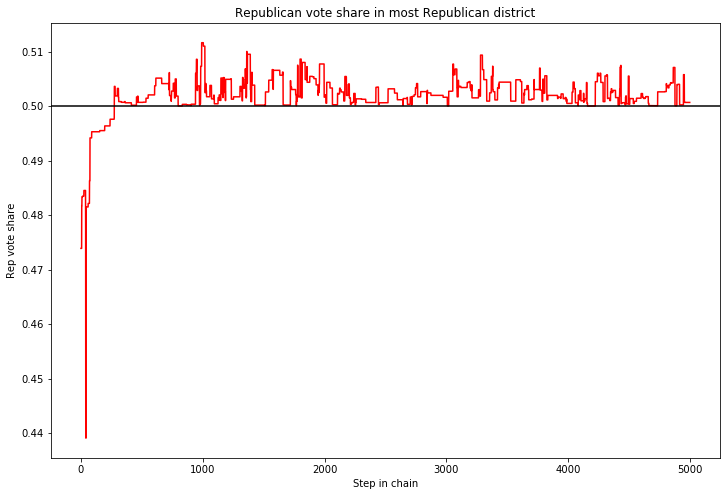

In [22]:
%%time
fig, rep_dist = plt.subplots(figsize=(12,8))

most_rep_dist = []
secmost_rep_dist = []
one_rep_plans = []

for plan in data:
    most_rep_dist.append(sorted(plan[3])[-1])
    secmost_rep_dist.append(sorted(plan[3])[-2])
    if sorted(plan[3])[-1] >= 0.5:
        one_rep_plans.append(plan)
    
rep_dist.plot(most_rep_dist, color="red")
# rep_dist.plot(secmost_rep_dist, color="red")
rep_dist.set_title("Republican vote share in most Republican district")
rep_dist.set_ylabel("Rep vote share")
rep_dist.set_xlabel("Step in chain")
rep_dist.axhline(y = 0.5, color="black")

In [56]:
len(one_rep_plans)

2000

In [57]:
copy_orp = one_rep_plans.copy()

In [58]:
len(copy_orp)

2000

In [13]:
unique_plans = []

for i in range(len(copy_orp) - 2):
    if copy_orp[i][3] != copy_orp[i+1][3]:
        unique_plans.append(copy_orp[i])

NameError: name 'copy_orp' is not defined

In [60]:
len(unique_plans)

1460

In [44]:
unique_plans[:10]

[[1,
  -0.011747941400197637,
  0.02915592418194033,
  (0.16952756822346288,
   0.41312316715542524,
   0.35827474352408,
   0.4263870244028026,
   0.4724795472448742,
   0.5008842382855132,
   0.35514057812609007,
   0.4210414165510288,
   0.30298423748093245,
   0.31966761840134184)],
 [1,
  -0.011769234730494404,
  0.029280230379153595,
  (0.16952756822346288,
   0.41312316715542524,
   0.35827474352408,
   0.42596979225828496,
   0.472683846086423,
   0.5008842382855132,
   0.35514057812609007,
   0.4210414165510288,
   0.30298423748093245,
   0.31966761840134184)],
 [1,
  -0.03220835796153576,
  0.04045866923656005,
  (0.16952756822346288,
   0.41312316715542524,
   0.35827474352408,
   0.42596979225828496,
   0.43186037024984303,
   0.5008842382855132,
   0.39995022399203584,
   0.4210414165510288,
   0.30298423748093245,
   0.31966761840134184)],
 [1,
  -0.032151902471012295,
  0.042385730257386414,
  (0.16952756822346288,
   0.41312316715542524,
   0.36337467352876285,
   0.425

CPU times: user 69.3 ms, sys: 6.68 ms, total: 76 ms
Wall time: 83.3 ms


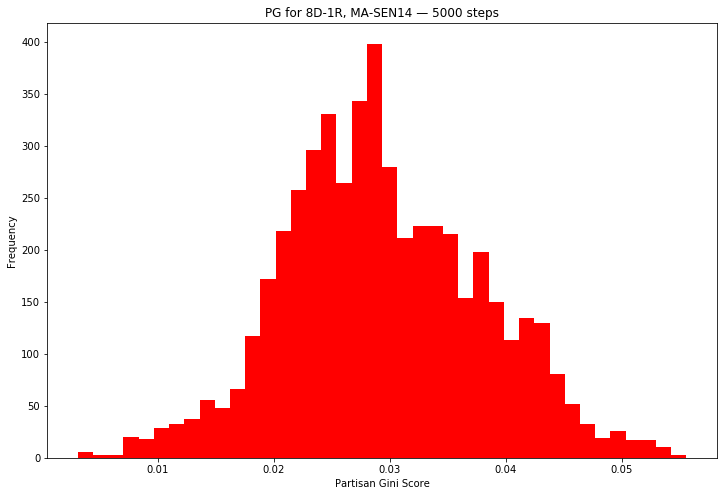

In [24]:
%%time
# all_plans = []
outliers = []

colors = ["lightgreen", "red"]

for plan in data:
    outliers.append(plan[2])
        
fig, pg_compare = plt.subplots(figsize=(12,8))

# pg_compare[0].hist(all_plans, color=colors[0])
pg_compare.hist(outliers, color=colors[1], bins=40)
pg_compare.set_title("PG for 8D-1R, MA-SEN14 — 5000 steps")
pg_compare.set_xlabel("Partisan Gini Score")
pg_compare.set_ylabel("Frequency")

In [50]:
len(all_plans)

1000

In [51]:
len(outliers)

657